In [58]:
import jax.numpy as jnp
import jax
import equinox as eqx
from jaxtyping import PRNGKeyArray
import cryojax as cx
import cryojax.simulator as cxs
import src.ensemble_sim as sim
import src.ensemble_sim_new as sim_new

from cryojax.image.operators import FourierGaussian
from cryojax.rotations import SO3
import dataclasses
import os
import jax_dataloader as jdl
from typing import Any, Callable, final
from typing_extensions import override

from cryojax.inference import distributions as dist


import numpyro
import numpyro.distributions as numpyro_dist

import logging
from functools import partial

import matplotlib.pyplot as plt

from cryojax.utils import get_filter_spec
from cryojax.utils._filtered_transformations import filter_vmap_with_spec
from cryojax.constants import get_tabulated_scattering_factor_parameters
from cryojax.io import read_atoms_from_pdb
from cryojax.image import operators as op


from cryojax.data import RelionParticleStack, RelionParticleParameters,AbstractParticleStack, RelionParticleDataset, AbstractDataset, write_starfile_with_particle_parameters
import cryo_reweighting.optimization as optimization


# Create list of pdb files for simulating images from

In [59]:
path_to_models="data/hsp90_models"
model_fnames = []
for model_fname in sorted(os.listdir(path_to_models)):
    model_fnames.append(model_fname)


# Define a weight distribution on the pdb files
## Here, evaluating a gaussian mixture pdf on the indices of the pdbs

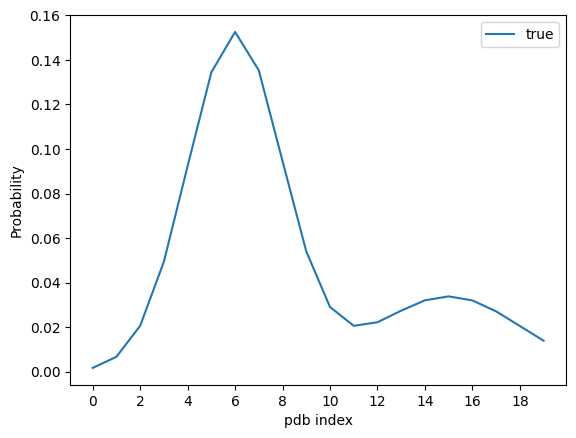

In [60]:
def GaussianMixture1D(weights, means, std_devs):
    weights = jnp.array(weights)
    means = jnp.array(means)
    std_devs = jnp.array(std_devs)
    mixing_dist = numpyro_dist.Categorical(probs=weights/jnp.sum(weights))
    component_dist = numpyro_dist.Normal(loc=means, scale=std_devs) 
    return numpyro_dist.MixtureSameFamily(mixing_dist, component_dist) 

weights = [1., 1./3.]
means = [6., 15.]
std_devs = [2.0, 3.0]
mixture = GaussianMixture1D(weights, means, std_devs)
samples = mixture.sample(jax.random.PRNGKey(0), (10000,))
 
# compute pdf output on a 1d grid
x = jnp.linspace(0, 19, 20)
dx = x[1] - x[0]
    
# normalize output to integrate to 1 on the grid 
true_weights = jnp.exp(mixture.log_prob(x))
true_weights /= dx*true_weights.sum() 
plt.plot(x, true_weights, label='true', color="C0")
plt.xticks(jnp.arange(0, 20, 2))
plt.xlabel('pdb index')
plt.ylabel('Probability')  
plt.legend()
plt.show()

jnp.save("true_weights.npy", true_weights)

# Define a config file for image simulation

In [61]:
# Bare bones config for this notebook
# Things that may need to be adjusted:
#   number of images, noise_snr
# Everything else, unlikely
config = {
"number_of_images": 10000,
"snr": 0.001,
"weights_models": true_weights,
"models_fnames": model_fnames, 
"path_to_models": path_to_models, 
"box_size": 128,
"rng_seed": 0,
"pixel_size": 1.6,
}

In [62]:
def _get_particle_stack_filter_spec(particle_stack):
    return get_filter_spec(particle_stack, _pointer_to_vmapped_stack)

def _pointer_to_vmapped_stack(particle_stack):
    output = (
        particle_stack.parameters.transfer_theory.ctf.defocus_in_angstroms,
        particle_stack.parameters.transfer_theory.ctf.astigmatism_in_angstroms,
        particle_stack.parameters.transfer_theory.ctf.astigmatism_angle,
        particle_stack.parameters.transfer_theory.ctf.phase_shift,
        particle_stack.parameters.pose.offset_x_in_angstroms,
        particle_stack.parameters.pose.offset_y_in_angstroms,
        particle_stack.parameters.transfer_theory.envelope.b_factor,
        particle_stack.parameters.transfer_theory.envelope.amplitude,
        particle_stack.parameters.pose.view_phi,
        particle_stack.parameters.pose.view_theta,
        particle_stack.parameters.pose.view_psi,
        particle_stack.image_stack,
    )
    return output

def _get_parameters_filter_spec(parameters):
    return get_filter_spec(parameters, _pointer_to_vmapped_parameters)

def _pointer_to_vmapped_parameters(parameters):
    output = (
        parameters.transfer_theory.ctf.defocus_in_angstroms,
        parameters.transfer_theory.ctf.astigmatism_in_angstroms,
        parameters.transfer_theory.ctf.astigmatism_angle,
        parameters.transfer_theory.ctf.phase_shift,
        parameters.transfer_theory.envelope.b_factor,
        parameters.transfer_theory.envelope.amplitude,
        parameters.pose
    )
    return output



In [63]:
# Generate RNG keys
number_of_images = config["number_of_images"]
keys = jax.random.split(jax.random.PRNGKey(0), number_of_images)

# make instrument confg
instrument_config = sim_new.instrument_config_from_params(config)

# make parameters
particle_parameters_vmap, particle_parameters_novmap = sim_new.make_particle_parameters(keys, instrument_config)
particle_parameters = eqx.combine(particle_parameters_vmap, particle_parameters_novmap)

# ... generate the a "starfile", I/O paradigm for software Relion
write_starfile_with_particle_parameters(
    particle_parameters,
    "./heterogeneous_relion_dataset.star",
    mrc_batch_size=50,
    overwrite=True,
)

In [64]:
# Create static image formation stuff
imaging_args = sim_new.build_image_formation_stuff(config)



In [65]:
var_est_seed = 0
key_var_est = jax.random.key(var_est_seed)
signal_variance = sim_new.estimate_signal_variance(
    key_var_est,
    n_images_for_estimation=10,
    mask_radius=config["box_size"]// 3,
    instrument_config=instrument_config,
    args=(
        imaging_args["potentials"],
        imaging_args["potential_integrator"],
        config["weights_models"],
        1.0,
    ),  # the last argument is the variance, not needed for this
)

# Simulate a dataset!

In [66]:
filter_spec_parameters = _get_parameters_filter_spec(particle_parameters)

In [67]:
key = jax.random.PRNGKey(config["rng_seed"])

args = (imaging_args["potentials"],
        imaging_args["potential_integrator"],
        imaging_args["weights"],
        signal_variance / config["snr"])
imaging_stack = sim_new.compute_image_stack_with_noise(key, number_of_images, particle_parameters, filter_spec_parameters, args)
noised_images = imaging_stack.image_stack
#print(noise_power_sq)
#plt.hist(noise_power_sq)
#print(jnp.mean(jnp.mean(noised_images**2,))

In [68]:
filter_spec_stack = _get_particle_stack_filter_spec(imaging_stack)
imaging_stack_vmap, imaging_stack_novmap = eqx.partition(
             imaging_stack, filter_spec_stack)

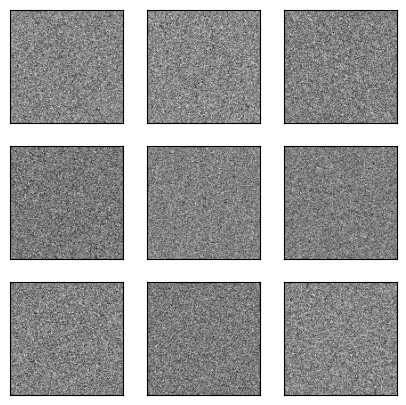

In [69]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(noised_images[idx,:], cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
#plt.savefig(f"figures/noised_images", dpi=300)


## Checking the conformation idx of each individual image
This is a quick check that the sampled conformations actually match the distribution we specified, and a simple use of the per-image conformation info we are tracking

In [70]:
# this is reading out the true conformation index of each image
#conformations = extra_info["conformation"]
#
## compute pdf output on a 1d grid
#x = jnp.linspace(0, 19, 20)
#dx = x[1] - x[0]
#    
## normalize output to integrate to 1 on the grid 
#true_weights = jnp.exp(mixture.log_prob(x))
#true_weights /= true_weights.sum()
#plt.plot(x, true_weights, label='true', color="C0")
#plt.hist(conformations, bins=20, range=(0, 19), density=True, label='conformations', color="C1")
#plt.xticks(jnp.arange(0, 20, 2))
#plt.xlabel('pdb index')
#plt.ylabel('Probability')  
#plt.legend()
#plt.show()


# Trying to compute likelihoods


In [71]:
@eqx.filter_jit
def compute_log_likelihood_single_conformation(
    potential, observed_imaging_stack_vmap, observed_imaging_stack_novmap):

    observed_imaging_stack = eqx.combine(observed_imaging_stack_vmap, observed_imaging_stack_novmap)
    parameters = observed_imaging_stack.parameters

    structural_ensemble = cxs.SingleStructureEnsemble(
        potential, parameters.pose
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble=structural_ensemble,
        potential_integrator=cxs.FourierSliceExtraction(interpolation_order=1),
        #potential_integrator = cxs.GaussianMixtureProjection(),
        transfer_theory=parameters.transfer_theory,
    )

    instrument_config = parameters.instrument_config

    simulated_imaging_pipeline = cxs.ContrastImagingPipeline(
        instrument_config, scattering_theory
    )

    simulated_distribution = dist.IndependentGaussianPixels(
        simulated_imaging_pipeline,
        variance=signal_variance / config["snr"],
    )
    return simulated_distribution.log_likelihood(observed_imaging_stack.image_stack) 

@eqx.filter_jit
@partial(eqx.filter_vmap, in_axes=(0, None, None), out_axes=0)
def compute_log_likelihood_all_images_single_conformation(atom_positions,imaging_stack_vmap, args):

    atom_identities, b_factors, parameter_table, imaging_stack_novmap = (
        args
    )

    parameters = imaging_stack_novmap.parameters
    instrument_config = parameters.instrument_config

    atom_potential = cxs.PengAtomicPotential(
        atom_positions,
        atom_identities,
        b_factors,
        scattering_factor_parameter_table=parameter_table,
    )

    real_voxel_grid = atom_potential.as_real_voxel_grid(
        (instrument_config.shape[0],) * 3,
        instrument_config.pixel_size,
        batch_size_for_z_planes=10,
    )

    voxel_potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
        real_voxel_grid,
        instrument_config.pixel_size
    )

    likelihoods = jax.lax.map(
        lambda x: compute_log_likelihood_single_conformation(
            potential=voxel_potential, observed_imaging_stack_vmap=x, observed_imaging_stack_novmap=imaging_stack_novmap
        ),
        xs=imaging_stack_vmap,
        batch_size=1000,
    )

    return likelihoods


In [72]:
pdb_fnames = config["models_fnames"]
path_to_models = config["path_to_models"]
filename = path_to_models + "/" + pdb_fnames[0]
_, atom_identities, b_factors = read_atoms_from_pdb(
    filename, get_b_factors=True)
parameter_table = get_tabulated_scattering_factor_parameters(atom_identities)

args = (atom_identities, b_factors, parameter_table, imaging_stack_novmap)

atom_positions_all = []
for i in range(len(pdb_fnames)):
    filename = path_to_models + "/" + pdb_fnames[i]
    atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    filename, get_b_factors=True
    )
    atom_positions_all.append(atom_positions)
atom_positions_all = jnp.stack(atom_positions_all)
print(atom_positions_all.shape)

(20, 9758, 3)


In [73]:
log_likelihood = compute_log_likelihood_all_images_single_conformation(atom_positions_all, imaging_stack_vmap, args).T
jnp.save("log_likelihood_hsp90_10kimages_high_noise.npy", log_likelihood)



<BarContainer object of 20 artists>

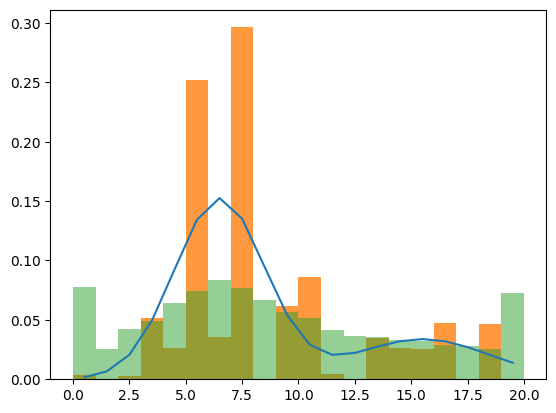

In [ ]:
nodes = jnp.arange(0, 20, 1) + 0.5
x = jnp.argmax(log_likelihood, axis = 1)
hard_weights, _ = jnp.histogram(x, bins =jnp.arange(0, 21, 1))
hard_weights /= jnp.sum(hard_weights)
log_likelihood_aux = log_likelihood - jnp.max(log_likelihood, 1)[:, jnp.newaxis]
    
# NOTE: we cannot exponentiate this if previous step hasn't happened 
weights = (1/log_likelihood.shape[1])*jnp.ones(log_likelihood.shape[1])
likelihood = jnp.exp(log_likelihood_aux)
model = jnp.sum(likelihood*weights, axis=1)
grad = jnp.mean(likelihood/model[:, jnp.newaxis], axis=0) 
weights = weights*grad
softmax_weights = optimization.multiplicative_gradient(log_likelihood, max_iterations=1)

plt.plot(nodes, true_weights, label='true', color="C0")
ensemble_weights = optimization.multiplicative_gradient(log_likelihood)
plt.bar(nodes, ensemble_weights, 
        width=1, label='EM Weights', color="C1", alpha=0.8)
plt.bar(nodes, hard_weights, 
        width=1, label='EM Weights', color="C2", alpha=0.5)


